In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import chi2
import scipy.special as fact
import pandas as pd
from sklearn.linear_model import LinearRegression

1.1.

In [2]:
data = scipy.io.loadmat('ex2file1.mat')
dlpfc1 = data['DLPFC1'].flatten()

In [3]:
def estimate_ar(x, n):

    T = len(x)

    y = x[n:]
    
    # Design matrix
    Z = np.column_stack([np.ones(T - n)] + [x[n - i - 1:T - i - 1] for i in range(n)])
    
    # Solve OLS
    params, *_ = np.linalg.lstsq(Z, y, rcond=None)
    params = np.asarray(params).flatten()

    residuals = y - Z @ params

    return params, residuals


class AR_model:
    def __init__(self, coeff, init, noise: str='normal',**kwargs):
        self.order = len(coeff)-1
        self.coeff = np.array(coeff)
        self.noise = noise
        self.config = kwargs
        self.init = np.array(init)
        self.xn_temp = self.init
        self.xn = None
        
    def __call__(self, length: int):
        xt_arr = np.zeros(length)
        
        if self.noise == 'normal':
            for i in range(length): 
                coeffs = self.coeff[-1:0:-1] # reverse the coeff to ensure, a_i*x_t-i
                xt_arr[i] = self.coeff[0] + coeffs @ self.xn_temp[-self.order:] + np.random.normal(**self.config)[0] 
                self.xn_temp = np.append(self.xn_temp, xt_arr[i])

            if type(self.xn) != type(None):
                self.xn = np.concatenate((self.xn, xt_arr))
            else:
                self.xn = xt_arr

            return np.array(xt_arr)
    
    def test_model(self,data):
        fitted = np.zeros(len(data))
        fitted[:self.order] = np.nan

        for t in range(self.order, len(data)):
            coeffs = self.coeff[-1:0:-1] # reverse the coeff to ensure, a_i*x_t-i
            fitted[t] = self.coeff[0] + coeffs @ data[t-self.order:t]

        return fitted

In [4]:
params, residuals = estimate_ar(dlpfc1, 4)
AR4 = AR_model(params,None)

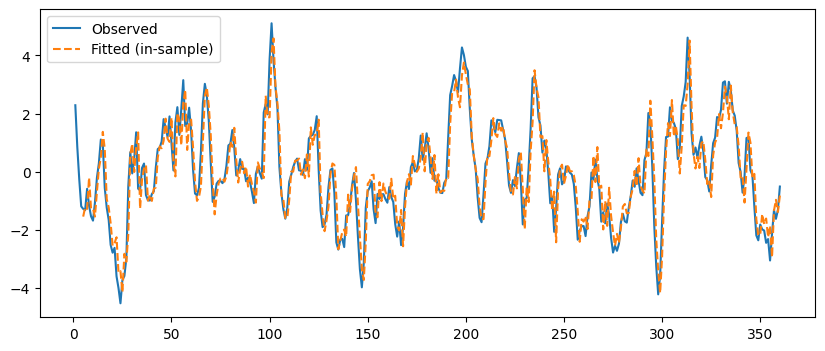

In [5]:
t = np.linspace(1, len(dlpfc1), len(dlpfc1))
fitted = AR4.test_model(dlpfc1)

plt.figure(figsize=(10,4))
plt.plot(t, dlpfc1, label='Observed')
plt.plot(t, fitted, '--', label='Fitted (in-sample)')
plt.legend()
plt.show()

1.2.

In [6]:
def log_likelihood_ar(x, params):

    n = len(params) - 1

    residual_sum = 0.0

    for t in range(n, len(x)):
        
        e = x[t] - (params[0] + sum(params[i + 1] * x[t - i - 1] for i in range(n)))

        residual_sum += e ** 2

    T = len(x) - n
    sigma_sq = residual_sum / T

    log_L = - T / 2 * np.log(2 * np.pi * sigma_sq) - (1 / (2 * sigma_sq)) * residual_sum

    return log_L, sigma_sq

In [7]:
log_L, _ = log_likelihood_ar(dlpfc1, params)
print(f'Log-likelihood of the AR(4) model: {log_L:.2f}')

Log-likelihood of the AR(4) model: -365.77


1.3.

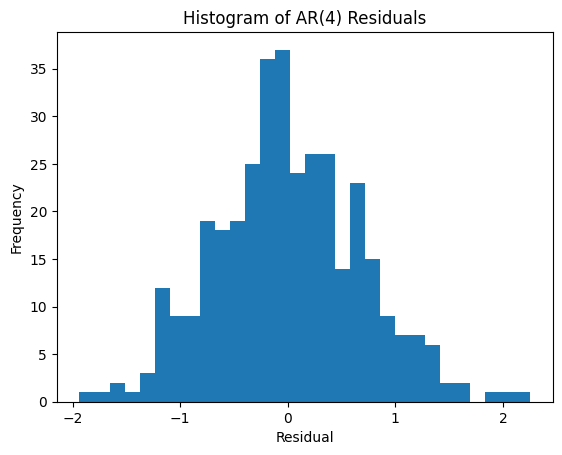

In [8]:
plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of AR(4) Residuals')
plt.show()

I would expect the residuals to look like a bell shaped curve centered at 0. They (should) behave like a Gaussian white‐noise process.

1.4.

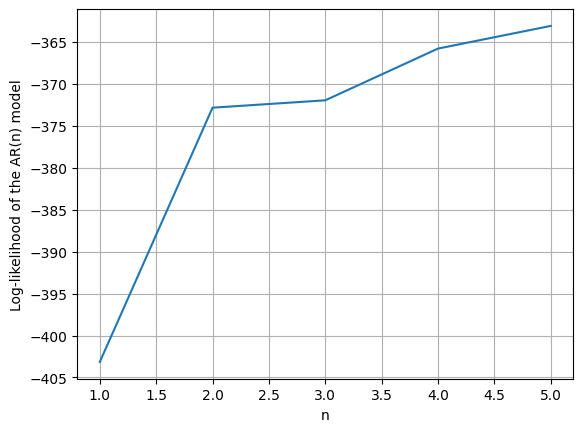

In [9]:
def plot_likelihood(x, n):

    log_Ls = np.zeros(n)

    for i in range(n):

        params, _ = estimate_ar(x, i+1)
        log_Ls[i], _ = log_likelihood_ar(x, params)

    plt.plot(np.linspace(1, n, n), log_Ls)
    plt.xlabel('n')
    plt.ylabel('Log-likelihood of the AR(n) model')
    plt.grid()
    plt.show()
        
plot_likelihood(dlpfc1, 5)

The log-likelihood increases with the model order. This is expected, because higher order models are more accurate.

1.5.

In [10]:
def log_L(x, n):

    params, _ = estimate_ar(x, n)
    log_L, _ = log_likelihood_ar(x, params)

    return log_L
    

def wilks_D(x, p):

    log_L_p  = log_L(x, p)
    log_L_pm = log_L(x, p-1)

    D = 2*(log_L_p - log_L_pm)

    return D

def calc_p(x, p):

    D = wilks_D(x, p)
    df = 1
    p_value = 1. - chi2.cdf(D, df)
    
    return p_value


In [11]:
for p in range(2, 6):
    p_val = calc_p(dlpfc1, p)
    if p_val < 0.05:
        print(f"AR({p-1}) vs AR({p}): p-value = {p_val:.4f} < 0.05")
    if p_val > 0.05:
        print(f"AR({p-1}) vs AR({p}): p-value = {p_val:.4f} > 0.05")

AR(1) vs AR(2): p-value = 0.0000 < 0.05
AR(2) vs AR(3): p-value = 0.1848 > 0.05
AR(3) vs AR(4): p-value = 0.0004 < 0.05
AR(4) vs AR(5): p-value = 0.0201 < 0.05


This shows, that the best order model is AR(2).

## Task 2

### 2.1

In [12]:
dlpfc1 = data['DLPFC1'].flatten()
dlpfc2 = data['DLPFC2'].flatten()
parietal1 = data['Parietal1'].flatten()
parietal2 = data['Parietal2'].flatten()

X = np.column_stack([dlpfc1, dlpfc2, parietal1, parietal2])

var_data = pd.DataFrame(X, columns=['DLPFC1', 'DLPFC2', 'Parietal1', 'Parietal2'])
var_data = var_data.to_numpy()
print(var_data)

[[ 2.2855  -0.29516 -3.0362  -4.5184 ]
 [ 0.85457 -2.6338  -4.5223  -1.9025 ]
 [-0.26151 -3.0811  -4.7146   0.47887]
 ...
 [-1.6229  -3.4713  -2.5944  -4.2907 ]
 [-1.3188  -3.1588  -2.6105  -3.5652 ]
 [-0.51186 -2.7217  -2.4909  -1.6222 ]]


In [13]:
class regVAR:
    def __init__(self, data):
        self.data = data

    def regress(self):
        X = self.data[:-1]
        y = self.data[1:]
        model = LinearRegression(fit_intercept=True).fit(X,y)
        A = model.coef_
        intercept = model.intercept_

        return A, intercept


In [14]:
test = regVAR(var_data)
A, intercept = test.regress()

print('coeff matrix A : ')
print(A)

print('a0 vector : ')
print(intercept)

coeff matrix A : 
[[ 0.90668653 -0.02035257  0.01568962 -0.03375742]
 [ 0.00975233  0.89853182 -0.00518382 -0.00724422]
 [-0.01223154  0.04526295  0.87266454  0.00158463]
 [ 0.15398133 -0.0979815   0.01444375  0.93634082]]
a0 vector : 
[ 0.0024904  -0.00690006  0.00287008  0.03277537]


The coefficients of A tell us how, which time series affect each other at a one time step lag. The diagonal A[i,i] are the affect of the time series on itself. Off diagonal values are the affects on each other. Most off diagonal values are small. The value of $a_{41}$ is a bit larger at 0.15 and tells us that the previous DLPFC1 increases the Parietal2 value.

Var(1) is stationary Iff all eigenvalues of the coeffiecient matrix $|\lambda| < 1$.

In [15]:
max(abs(np.linalg.eigvals(A))) < 1

True

Checking the max eigenvalue and confirming that it is less then 1, and thus the VAR model is stationary.

## Task 3

3.2.

In [16]:
def create_poisson_ts(T, k, A1, A2, mu0, a0):
    
    # Initialize
    c_series = np.zeros((T, k), dtype=int)
    c_series[0] = np.random.poisson(mu0)
    c_series[1] = np.random.poisson(mu0)

    # Generate time series
    for t in range(2, T):
        log_lambda = a0 + A1 @ c_series[t-1] + A2 @ c_series[t-2]
        lambda_t = np.exp(log_lambda)
        c_series[t] = np.random.poisson(lambda_t)
    
    # Print some steps
    for t in range(5):
        print(f"t={t}, counts={c_series[t]}")

    return c_series

In [17]:
A1 = np.array([[0.2, -0.1], [0.1, 0.1]])
A2 = np.array([[0.1, -0.1], [0.1, 0.1]])
mu0 = np.array([0.5, 0.5])
a0  = np.array([0.0, 0.0])

T = 1000
k = 2

poisson_ts = create_poisson_ts(T, k, A1, A2, mu0, a0)

t=0, counts=[2 0]
t=1, counts=[0 0]
t=2, counts=[0 2]
t=3, counts=[1 1]
t=4, counts=[0 1]


3.3.

The log-likelihood landscape for a Poisson time series model is not guaranteed to be convex or smooth. 
In this case (autoregressive Poisson model) where lambda depends on the past time steps, there is non-linearity and feedback.
Knowing the shape of the log-likelihood landscape is important because it affects how easy it is to find the best model parameters. If the shape is smooth, it's easier to find the best fit. If not, it can be very difficult. It also tells us how certain we can be about our estimates.

3.4.

In [18]:
def poisson_log_L(T, k, ts, A1, A2, a0):

    p = 2
    log_lambda=np.zeros((k, T-2))
    
    for t in range(2, T):
        
        log_lambda[:,t-2] = a0 + A1@ts[t-1] + A2@ts[t-2]

    lamdba = np.exp(log_lambda)
    c_vals = ts[2:].T
    
    log_lik = c_vals*log_lambda - lamdba - fact.gammaln(c_vals+1)

    return np.sum(log_lik)

variation = np.linspace(0.0, 0.4, 41)
log_ls = np.zeros((len(variation), len(variation)))

for i, val1 in enumerate(variation):

    for j, val2 in enumerate(variation):

        A1[0,0]=val1
        A2[1,0]=val2
        
        l = poisson_log_L(1000, 2, poisson_ts, A1, A2, a0)

        log_ls[i,j]=l


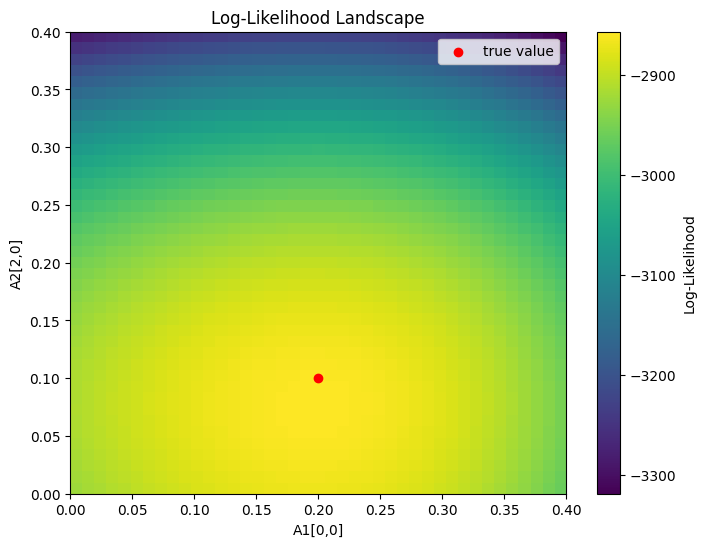

In [19]:
plt.figure(figsize=(8, 6))
plt.imshow(log_ls.T, origin='lower', extent=[0, 0.4, 0, 0.4], aspect='auto', cmap='viridis')
plt.colorbar(label='Log-Likelihood')
plt.scatter([0.2],[0.1],c='red', label='true value')
plt.legend()
plt.xlabel('A1[0,0]')
plt.ylabel('A2[2,0]')
plt.title('Log-Likelihood Landscape')
plt.show()

The true parameter pair is at a peak in the log likelihood. 